In [1]:
import pandas as pd 
import numpy as np
from scipy import linalg
from scipy.spatial.distance import pdist, squareform
# import networkx as nx
# import sys
import random

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.metrics import DistanceMetric
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import adjusted_rand_score

from matplotlib import rcParams, cycler, figure
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns

In [2]:
def norm_and_pca_from_df(df):
    '''
    Function processes the data using Principal component analysis(PCA)
    Args:
        df : Dataframe 
    Returns normalized dataframe and principal component of df
    '''
    
    df_normalized = pd.DataFrame()
    cols = list(df.columns)
    df_normalized[cols] = pd.DataFrame(normalize(MinMaxScaler().fit_transform(df[cols])))
    df_normalized.index = df.index
    
    df_pca = pd.DataFrame(PCA(n_components = 2).fit_transform(df_normalized))
    df_pca.columns = ['P1', 'P2']
    df_pca.index = df.index
    
    return df_normalized, df_pca

In [3]:
# Load and transform dataset 0
df_csv = pd.read_csv("test.csv")
index_labels = df_csv["points"]
class_labels = df_csv["class"]
df_data = df_csv[["x_coordinate","y_coordinate"]]

df_normalized = df_csv.copy()
df_pca = df_csv.copy()

df_normalized[["x_coordinate","y_coordinate"]], df_pca[["x_coordinate","y_coordinate"]] = norm_and_pca_from_df(df_data)

In [4]:
df_csv

,points,x_coordinate,y_coordinate,class
0,p1,1,7,1
1,p2,1,6,1
2,p3,6,2,2
3,p4,8,1,2
4,p5,10,2,2


In [5]:
df_data

,x_coordinate,y_coordinate
0,1,7
1,1,6
2,6,2
3,8,1
4,10,2


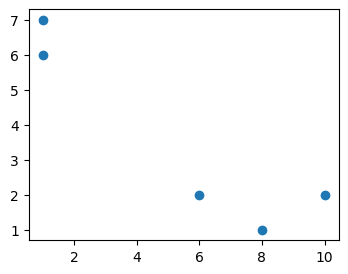

In [6]:
plt.rcParams["figure.figsize"] = (4,3)
plt.scatter(df_data['x_coordinate'], df_data['y_coordinate'])

### Abhivanth --start--

In [7]:
# Pairwise distances
dimension = df_data.shape[0]
dist_ = pdist(df_data)
dist_mat = np.zeros([dimension, dimension])
dist = iter(dist_)
for i in range(dimension):
    for j in range(i+1, dimension):  
        d = next(dist)
        dist_mat[i,j] = d
        dist_mat[j,i] = d

In [8]:
dist_mat

array([[ 0.        ,  1.        ,  7.07106781,  9.21954446, 10.29563014],
       [ 1.        ,  0.        ,  6.40312424,  8.60232527,  9.8488578 ],
       [ 7.07106781,  6.40312424,  0.        ,  2.23606798,  4.        ],
       [ 9.21954446,  8.60232527,  2.23606798,  0.        ,  2.23606798],
       [10.29563014,  9.8488578 ,  4.        ,  2.23606798,  0.        ]])

#### Fully-connected (Self-tuning)

In [9]:
#calculate local sigma
sigmas = np.zeros(dimension)
for i in tqdm(range(len(dist_mat))):
    sigmas[i] = sorted(dist_mat[i])[2]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 8655.19it/s]


In [10]:
sigmas

array([7.07106781, 6.40312424, 4.        , 2.23606798, 4.        ])

In [11]:
# Adjaceny matrix with optimal sigma
adjacency_matrix = np.zeros([dimension, dimension])
dist = iter(dist_)
for i in tqdm(range(dimension)):
    for j in range(i+1, dimension):  
        d = np.exp(-1*next(dist)**2/(sigmas[i]*sigmas[j]))
        adjacency_matrix[i,j] = d
        adjacency_matrix[j,i] = d

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5000.36it/s]


In [12]:
adjacency_matrix

array([[0.        , 0.97815581, 0.17071378, 0.00462688, 0.0235727 ],
       [0.97815581, 0.        , 0.20173889, 0.00569376, 0.02265865],
       [0.17071378, 0.20173889, 0.        , 0.57177084, 0.36787944],
       [0.00462688, 0.00569376, 0.57177084, 0.        , 0.57177084],
       [0.0235727 , 0.02265865, 0.36787944, 0.57177084, 0.        ]])

#### Epsilon-neighbourhood Graph

In [13]:
# Adjaceny matrix with epsilon threshold
epsilon = 5.00
adjacency_matrix = np.zeros([dimension, dimension])
dist = iter(dist_)

for i in tqdm(range(dimension)):
    for j in range(i+1, dimension):
        if next(dist) < epsilon:
            d = 1
        else:
            d = 0
        adjacency_matrix[i,j] = d
        adjacency_matrix[j,i] = d

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


In [14]:
adjacency_matrix

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.]])

#### k-NN Graph 

In [63]:
k = 2
adjacency_matrix = np.zeros([dimension, dimension])

for i in range(dimension):
    # Sort distances for node i and get indices of the k nearest neighbors
    sorted_indices = np.argsort(dist_mat[i])
    k_nearest_indices = sorted_indices[1:k+1]  # Exclude the node itself

    # Update the adjacency matrix
    adjacency_matrix[i, k_nearest_indices] = 1

In [64]:
adjacency_matrix

array([[0., 1., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.]])

#### Mutual k-NN Graph

In [65]:
k = 2
adjacency_matrix = np.zeros([dimension, dimension])

for i in range(dimension):
    # Sort distances for node i and get indices of the k nearest neighbors
    sorted_indices = np.argsort(dist_mat[i])
    k_nearest_indices = sorted_indices[1:k+1]  # Exclude the node itself

    for neighbor in k_nearest_indices:
        # Check if node i is also among the k-nearest neighbors of the current neighbor
        neighbor_sorted_indices = np.argsort(dist_mat[neighbor])
        if i in neighbor_sorted_indices[1:k+1]:
            # Connect nodes if they are mutual k-nearest neighbors
            adjacency_matrix[i, neighbor] = 1
            adjacency_matrix[neighbor, i] = 1

In [66]:
adjacency_matrix

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.]])

### Abhivanth --end--

### Evelina --start--

In [ ]:
# Calculate degree matrix
degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)

In [ ]:
degree_matrix

#### Normalized Symmetric Laplacian

In [ ]:
# Normalized Symmetric laplacian matrix
d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
laplacian_matrix_normalized = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)

In [ ]:
laplacian_matrix_normalized

#### Normalized Random Walk Laplacian

In [ ]:
# Normalized Random Walk laplacian matrix
d_inverse = linalg.fractional_matrix_power(degree_matrix, -1)
laplacian_matrix_normalized = np.matmul(d_inverse, adjacency_matrix)

In [ ]:
laplacian_matrix_normalized

In [ ]:
# Calculating eigenvalues and eigenvectors no. of clusters k

k = 2

e, v = np.linalg.eigh(laplacian_matrix_normalized)
X = v[:, -1*k:]
# row_sums = X.sum(axis=1)
# Y = X / row_sums[:, np.newaxis]

In [ ]:
e

In [ ]:
v

In [ ]:
X

In [ ]:
plt.rcParams["figure.figsize"] = (4,3)
plt.scatter(range(len(e)), e);
plt.xticks(range(0,len(e)));

### Evelina --end--